### Read the README.md before

In [1]:
import json 
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta


# Import the Files

In [2]:
df_relinquished = pd.read_csv('data/season_2018_relinquished.csv')
df_acquired = pd.read_csv('data/season_2018_acquired.csv')
df_players = pd.read_csv('data/season_2018_players.csv')
df_teams = pd.read_csv('data/season_2018_teams.csv')

with open('injury_types.json') as json_file: 
    injury_types = json.load(json_file)

with open('teams_dict.json') as json_teams: 
    teams_dict = json.load(json_teams)


***Relinquished***: When a player appears to the injury list or missed a game. 
    
    - date of the statement, team, name of the player, notes 

***Acquired***: When a player is no longer on the injury list 

    - Same columns 

***Players***: Each game where a player participated

    - Date, Player, Minutes played 

***Teams***: Each game played by a team 

    - Date, team

***Injury Types***: Json file with keywords to describe the reason of abscence. 
     
     - 3 reasons of abs: **injuries**, illness, personal_reasons
     - For each reason: different detailed keywords 
     - For Injuries: different types are also detailed 

***Teams Dict***: Corresponding team names and abreviations



In [3]:
# Transform date columns to Timestamp
df_relinquished['date'] = pd.to_datetime(df_relinquished['date'], format = '%Y-%m-%d')
df_acquired['date'] = pd.to_datetime(df_acquired['date'], format = '%Y-%m-%d')
df_players['Date'] = pd.to_datetime(df_players['Date'], format = '%Y%m%d')
df_teams['Date'] = pd.to_datetime(df_teams['Date'], format = '%Y%m%d')

# Extract Datails from Relinquished 

In [4]:
df_injuries = df_relinquished.copy()
df_injuries.head()

,key,date,team,name,notes
0,WilsonD20181017rel,2018-10-17,Bucks,D.J. Wilson,placed on IL with strained right hamstring
1,DuvalT20181017rel,2018-10-17,Bucks,Trevon Duval,left eye injury (DTD)
2,SmithJ20181017rel,2018-10-17,Cavaliers,J.R. Smith,sore right elbow (DTD)
3,NanceL20181017rel,2018-10-17,Cavaliers,Larry Nance Jr.,placed on IL with sprained right ankle
4,WatanabeY20181017rel,2018-10-17,Grizzlies,Yuta Watanabe,placed on IL


Instead of doing basic NLP with word recognition (like some people on Kaggle already did), I prefer using a list of body parts and injuries types. I believe this method can lead to a more precise analysis. 

In [5]:
reasons = []
types = []
injury_locations = []
for note in df_injuries['notes']: 

    if len([ele for ele in injury_types['injuries'] if ele in note]) > 0: 
        reason = 'injury'
        type_ = [ele for ele in injury_types['types'] if ele in note]
        injury_location = [ele for ele in injury_types['injuries'] if ele in note]

    elif len([ele for ele in injury_types['personal_reasons'] if ele in note]) > 0: 
        reason = 'personal_reasons'
        type_ = [ele for ele in injury_types['personal_reasons'] if ele in note]
        injury_location = None

    else: 
        reason = 'illness'
        if len([ele for ele in injury_types['illness'] if ele in note]) > 0: 
            type_ = [ele for ele in injury_types['illness'] if ele in note]
        else: 
            type_ = None 
        injury_location = None
    
    reasons.append(reason)
    if (type_ == None) or (type_ == []): 
        types.append(type_)
    else: 
        types.append(type_[0])
    
    if (injury_location == None) or (type == []): 
        injury_locations.append(injury_location)
    else: 
        injury_locations.append(injury_location[0])


In [6]:
df_injuries['reason'] = reasons
df_injuries['type'] = types
df_injuries['injury_location'] = injury_locations
df_injuries.head()

,key,date,team,name,notes,reason,type,injury_location
0,WilsonD20181017rel,2018-10-17,Bucks,D.J. Wilson,placed on IL with strained right hamstring,injury,strained,hamstring
1,DuvalT20181017rel,2018-10-17,Bucks,Trevon Duval,left eye injury (DTD),injury,injury,eye
2,SmithJ20181017rel,2018-10-17,Cavaliers,J.R. Smith,sore right elbow (DTD),injury,sore,elbow
3,NanceL20181017rel,2018-10-17,Cavaliers,Larry Nance Jr.,placed on IL with sprained right ankle,injury,sprained,ankle
4,WatanabeY20181017rel,2018-10-17,Grizzlies,Yuta Watanabe,placed on IL,illness,None,None


# Merge with Acquired 

In [7]:
missed_games = []
missed_days = []
return_dates = []

for i in range(len(df_injuries)): 
    name = df_injuries.iloc[i]['name']
    team = df_injuries.iloc[i]['team']  
    statement_date = df_injuries.iloc[i]['date']

    name_acquired = df_acquired[(df_acquired['name'] == name) & (df_acquired['date'] > statement_date)]

    player = df_players[(df_players['Team'] == name) & (df_players['Date'] > statement_date)]
    
    if len(player) == 0: # Temporary line. Some names aren't the same between my Injuries data and my game data. 
        missed_games.append(None)
        missed_days.append(None)
        return_dates.append(None)
        continue 

    team = teams_dict[team]
    team_calendar = df_teams[(df_teams['Team']== team) & (df_teams['Date'] > statement_date)]

    if len(name_acquired) > 0: # We find the end of the absence of the player on the acquired dataset. 
        return_date = name_acquired.iloc[0]['date']
        
        # Double check with the game data 
        next_game_played = player.iloc[0]['Date']
        if next_game_played < return_date: # We double check this date with the next game he played, based on a game dataset. 
            return_date = next_game_played # We change the return_date if the older one wasn't correct. 
    elif len(player) > 0: 
        return_date = player.iloc[0]['Date']
    else: 
        return_date = 'Still absent or Retired' # TODO: Chech if the player is retired or not


    return_dates.append(return_date)
    if isinstance(return_date, str):
        missed_games.append(None)
        missed_days.append(None)
        
    else:
        missed_days.append((return_date - statement_date).days) # Calculated days between the begining and the end of the absence
        missed_games.append(len(team_calendar[team_calendar['Date'] < return_date])) # During this period, we calculate the number of games his team played, and so he missed



In [8]:
df_injuries['missed_days'] = missed_days
df_injuries['missed_games'] = missed_games
df_injuries['return_date'] = return_dates
df_injuries.head()

,key,date,team,name,notes,reason,type,injury_location,missed_days,missed_games,return_date
0,WilsonD20181017rel,2018-10-17,Bucks,D.J. Wilson,placed on IL with strained right hamstring,injury,strained,hamstring,49.0,21.0,2018-12-05
1,DuvalT20181017rel,2018-10-17,Bucks,Trevon Duval,left eye injury (DTD),injury,injury,eye,114.0,52.0,2019-02-08
2,SmithJ20181017rel,2018-10-17,Cavaliers,J.R. Smith,sore right elbow (DTD),injury,sore,elbow,2.0,0.0,2018-10-19
3,NanceL20181017rel,2018-10-17,Cavaliers,Larry Nance Jr.,placed on IL with sprained right ankle,injury,sprained,ankle,NaN,NaN,NaT
4,WatanabeY20181017rel,2018-10-17,Grizzlies,Yuta Watanabe,placed on IL,illness,None,None,10.0,3.0,2018-10-27


# Deal with duplicates

In [9]:
df_analysis = df_injuries.dropna( subset = ['missed_days']) # For the analysis we remove all the absence we are unsure about their end. 

for i in range(len(df_analysis)): 
    name = df_analysis.iloc[i]['name']
    start_date = df_analysis.iloc[i]['date']
    end_date = df_analysis.iloc[i]['return_date']

    possible_duplicates = df_analysis[(df_analysis['name'] == name) & (df_analysis['date'] > start_date) & (df_analysis['return_date'] < end_date)]
    if len(possible_duplicates) != 0: 
        print('Duplicate found', i)
        # TODO: Add some code to remove the duplicate line when I'll find a case.

Any duplicate is found is the dataframe. It seems I saw some in the dataset of another year. I'll if it's the case later!
# Analysis

In [10]:

months = [x.strftime('%B') for x in df_analysis['date']]
df_analysis['month'] = months
df_analysis.head()

,key,date,team,name,notes,reason,type,injury_location,missed_days,missed_games,return_date,month
0,WilsonD20181017rel,2018-10-17,Bucks,D.J. Wilson,placed on IL with strained right hamstring,injury,strained,hamstring,49.0,21.0,2018-12-05,October
1,DuvalT20181017rel,2018-10-17,Bucks,Trevon Duval,left eye injury (DTD),injury,injury,eye,114.0,52.0,2019-02-08,October
2,SmithJ20181017rel,2018-10-17,Cavaliers,J.R. Smith,sore right elbow (DTD),injury,sore,elbow,2.0,0.0,2018-10-19,October
4,WatanabeY20181017rel,2018-10-17,Grizzlies,Yuta Watanabe,placed on IL,illness,None,None,10.0,3.0,2018-10-27,October
5,HamiltonD20181017rel,2018-10-17,Hawks,Daniel Hamilton,torn rotator cuff in shoulder (out indefinitely),injury,torn,shoulder,14.0,6.0,2018-10-31,October


In [11]:
df_analysis['reason'].value_counts()

injury              786
illness             314
personal_reasons     70
Name: reason, dtype: int64

The large majority of absence are due to injuries

In [12]:
injury_analysis = df_analysis[df_analysis['reason'] == 'injury']
injury_analysis.head()

,key,date,team,name,notes,reason,type,injury_location,missed_days,missed_games,return_date,month
0,WilsonD20181017rel,2018-10-17,Bucks,D.J. Wilson,placed on IL with strained right hamstring,injury,strained,hamstring,49.0,21.0,2018-12-05,October
1,DuvalT20181017rel,2018-10-17,Bucks,Trevon Duval,left eye injury (DTD),injury,injury,eye,114.0,52.0,2019-02-08,October
2,SmithJ20181017rel,2018-10-17,Cavaliers,J.R. Smith,sore right elbow (DTD),injury,sore,elbow,2.0,0.0,2018-10-19,October
5,HamiltonD20181017rel,2018-10-17,Hawks,Daniel Hamilton,torn rotator cuff in shoulder (out indefinitely),injury,torn,shoulder,14.0,6.0,2018-10-31,October
6,DedmonD20181017rel,2018-10-17,Hawks,Dewayne Dedmon,placed on IL with left ankle injury,injury,injury,ankle,7.0,2.0,2018-10-24,October


Text(0.5, 1.0, 'Number of injuries for each month')

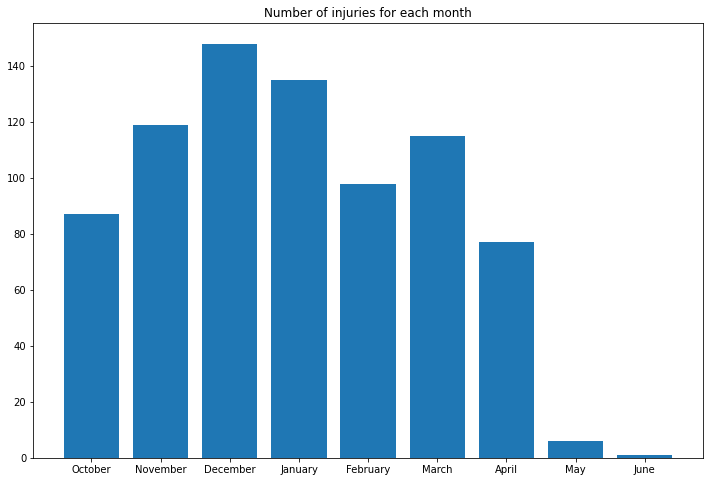

In [13]:
months = [ "October", "November", "December", "January", "February", "March", "April", "May", "June", "Jully", "August", "September",]
injury_month = injury_analysis.groupby('month').size().reset_index(name = 'count')
injury_month['month'] = pd.Categorical(injury_month['month'], categories=months, ordered = True)
injury_month = injury_month.sort_values(by='month')

fig = plt.figure(figsize = (12,8))
plt.bar(injury_month['month'], injury_month['count'])
plt.title('Number of injuries for each month')

In [14]:
injury_analysis['injury_location'].value_counts()

ankle         172
knee          165
back           64
hamstring      51
foot           42
hip            39
quadricep      27
concussion     23
toe            22
shoulder       21
groin          17
calf           15
thumb          12
neck           12
Achilles       11
wrist          11
adductor       10
finger         10
hand           10
heel           10
elbow           8
thigh           8
head            6
leg             4
eye             3
nose            3
pelvis          2
oblique         2
abdominal       2
tailbone        1
mouth           1
shin            1
thoracic        1
Name: injury_location, dtype: int64

As expected, the ankle and knee are responsible of a large part of all injuries 

## Ankle Analysis 

In [15]:
ankle_analysis = injury_analysis[injury_analysis['injury_location'] == 'ankle']
ankle_analysis.head()

,key,date,team,name,notes,reason,type,injury_location,missed_days,missed_games,return_date,month
6,DedmonD20181017rel,2018-10-17,Hawks,Dewayne Dedmon,placed on IL with left ankle injury,injury,injury,ankle,7.0,2.0,2018-10-24,October
8,WaitersD20181017rel,2018-10-17,Heat,Dion Waiters,placed on IL with left ankle injury,injury,injury,ankle,77.0,34.0,2019-01-02,October
11,EllingtonW20181017rel,2018-10-17,Heat,Wayne Ellington,sore left ankle (DTD),injury,sore,ankle,10.0,3.0,2018-10-27,October
17,MudiayE20181017rel,2018-10-17,Knicks,Emmanuel Mudiay,placed on IL with sprained right ankle,injury,sprained,ankle,12.0,5.0,2018-10-29,October
18,HicksI20181017rel,2018-10-17,Knicks,Isaiah Hicks,placed on IL with sprained left ankle,injury,sprained,ankle,107.0,49.0,2019-02-01,October


In [16]:
ankle_analysis['type'].value_counts()

sprained    116
sore         33
injury       21
surgery       2
Name: type, dtype: int64

In [17]:
ankle_injury = list(ankle_analysis['type'].unique())

In [18]:
for injury in ankle_injury: 
    missed_games = ankle_analysis[ankle_analysis['type'] == injury]['missed_days'].mean()
    print(injury, "%.2f" % missed_games)

injury 22.29
sore 4.36
sprained 10.70
surgery 40.00


The average number of missed days with each ankle injury type

Text(0.5, 1.0, 'Number of ankle injuries for each month')

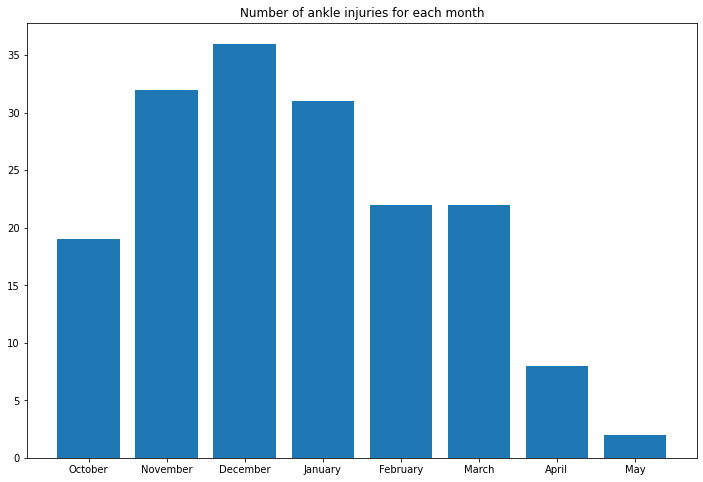

In [19]:
ankle_month = ankle_analysis.groupby('month').size().reset_index(name = 'count')
ankle_month['month'] = pd.Categorical(ankle_month['month'], categories=months, ordered = True)
ankle_month = ankle_month.sort_values(by='month')

fig = plt.figure(figsize = (12,8))
plt.bar(ankle_month['month'], ankle_month['count'])
plt.title('Number of ankle injuries for each month')

## Recidivism
The aim is to find absence not due to illnes after the return_date during the same season 

Text(0.5, 0, 'Time after the return date')

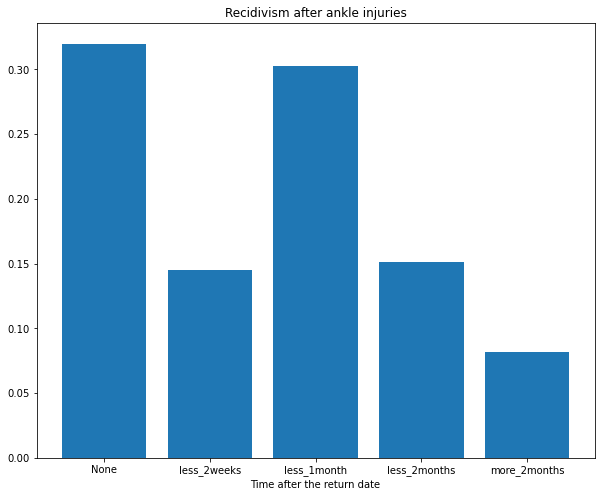

In [24]:
next_injury = {
    'None': 0, 
    'less_2weeks': 0, 
    'less_1month': 0, 
    'less_2months': 0, 
    'more_2months': 0
}

absence_reason = []
next_injury_location = []

def get_next_injury(future_absences):
    reason = future_absences.iloc[0]['reason']

    if reason == 'injury': 
        location = future_absences.iloc[0]['injury_location']
    else: 
        location = None
    return reason, location



for i in range(len(ankle_analysis)): 
    name = ankle_analysis.iloc[i]['name']
    return_date = ankle_analysis.iloc[i]['return_date']
    future_absences = df_injuries[(df_injuries['date'] > return_date) & (df_injuries['name'] == name)]
    if len(future_absences) == 0: 
        next_injury['None'] += 1 

        absence_reason.append(None)
        next_injury_location.append(None)

    elif future_absences.iloc[0]['date'] < return_date + relativedelta(days = 7): 
        next_injury['less_2weeks'] += 1

        reason, location = get_next_injury(future_absences)
        absence_reason.append(reason)
        next_injury_location.append(location)


    elif future_absences.iloc[0]['date'] < return_date + relativedelta(months = 1): 
        next_injury['less_1month'] +=1
        
        reason, location = get_next_injury(future_absences)
        absence_reason.append(reason)
        next_injury_location.append(location)


    elif future_absences.iloc[0]['date'] < return_date + relativedelta(months = 2): 
        next_injury['less_2months'] += 1 
        
        reason, location = get_next_injury(future_absences)
        absence_reason.append(reason)
        next_injury_location.append(location)


    else: 
        next_injury['more_2months'] +=1 
        
        reason, location = get_next_injury(future_absences)
        absence_reason.append(reason)
        next_injury_location.append(location)


# Express values in percentages
for k,v in next_injury.items(): 
    next_injury[k] = v / len(ankle_analysis)

plt.figure(figsize = (10,8))
plt.bar(range(len(next_injury)), list(next_injury.values()), align='center')
plt.xticks(range(len(next_injury)), list(next_injury.keys()))
plt.title('Recidivism after ankle injuries')
plt.xlabel('Time after the return date')

In [25]:
ankle_analysis['next_absence_reason'] = absence_reason
ankle_analysis['next_injury_location'] = next_injury_location
ankle_analysis.head()

,key,date,team,name,notes,reason,type,injury_location,missed_days,missed_games,return_date,month,next_absence_reason,next_injury_location
6,DedmonD20181017rel,2018-10-17,Hawks,Dewayne Dedmon,placed on IL with left ankle injury,injury,injury,ankle,7.0,2.0,2018-10-24,October,personal_reasons,None
8,WaitersD20181017rel,2018-10-17,Heat,Dion Waiters,placed on IL with left ankle injury,injury,injury,ankle,77.0,34.0,2019-01-02,October,injury,head
11,EllingtonW20181017rel,2018-10-17,Heat,Wayne Ellington,sore left ankle (DTD),injury,sore,ankle,10.0,3.0,2018-10-27,October,personal_reasons,None
17,MudiayE20181017rel,2018-10-17,Knicks,Emmanuel Mudiay,placed on IL with sprained right ankle,injury,sprained,ankle,12.0,5.0,2018-10-29,October,injury,shoulder
18,HicksI20181017rel,2018-10-17,Knicks,Isaiah Hicks,placed on IL with sprained left ankle,injury,sprained,ankle,107.0,49.0,2019-02-01,October,illness,None


In [26]:
ankle_analysis['next_absence_reason'].value_counts()

injury              85
illness             26
personal_reasons     6
Name: next_absence_reason, dtype: int64

85/117, or 72% of the following absence after a injury are new injuries

In [27]:
ankle_analysis[ankle_analysis['next_absence_reason'] == 'injury']['next_injury_location'].value_counts()

ankle         31
knee          10
shoulder       6
foot           5
back           5
adductor       4
calf           3
elbow          3
hip            3
concussion     3
groin          2
hand           2
finger         2
head           1
abdominal      1
heel           1
Achilles       1
hamstring      1
shin           1
Name: next_injury_location, dtype: int64

31/85 new injuries (36%) are ankle injury again (**real recidivism** by definition), 10/85 (11%) are knee injury. 